___
due to sensitive information, actual real numbers will not be used here. instead it will be substituted with real stocks

This notebook will show the concept of spend optimization based on returns and variance. It will answer the question of:
1. if you have $100, where will you spend it on?
1. the spend allocation should give us the maximum returns and lowest variance

In [348]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime 
from dateutil.relativedelta import relativedelta
import cvxopt as opt
from cvxopt import blas, solvers, matrix

### Context of intention of analysis
- Lets say we have `$100`, where should we spend on paid acquisition of users?
- So that ROI will be more than current and also take on lesser risk
- This becomes a 'portfolio' optimization problem, and each channel and geo can be considered as 1 stock. We will end up with a lot of options to choose from
    - Lets use `YouTube` for example. `YouTube` singapore will be considered as 1 stock
- And we will choose a bunch of stocks that will return us the maximum returns and lowest variance
- Here, we will not be using the real data i had, but instead use real stock information to illustrate the idea

### Scope of analysis
- Data pull
- Generate covariance and correlation matrix
- Pick stocks based on optimization
- Get portfolio return and variance (and sharpe ratio)
- Plot efficient frontier

### Data pull
- the data used will be from the previous blog post of k-means: [link](https://medium.com/uptick-blog/stock-picks-using-k-means-clustering-4330c6c4e8de)
- we will be focusing on the golden cluster identified, which has 57 stocks with an average of ~24% return and ~5% variance

In [2]:
rawdata = (
    pd.read_csv('data/aggregate_tickers_return_variance.csv', index_col=0)
    .reset_index()
)

rawdata_yearly_returns = (
    pd.read_csv("data/yearly_returns_for_tickers.csv")
)

#### Query the golden cluster stocks only

In [260]:
golden_cluster_stocks = (
    rawdata
    .query("ticker in ('ADSK','ANTM', 'AZPN', 'CACC', 'CHDN', 'CHE', 'CI', 'COO', 'DENN',\
       'FDEF', 'FICO', 'FIS', 'FIX', 'HELE', 'HIFS', 'ICUI', 'IHC',\
       'INTU', 'IT', 'JKHY', 'KAI', 'KWR', 'LFUS', 'LII', 'LION', 'LOW',\
       'MCO', 'MLAB', 'MMSI', 'MOH', 'MSFT', 'MTD', 'MTN', 'NSP', 'OLBK',\
       'OMCL', 'ORLY', 'PRSC', 'RDI', 'RHT', 'RMD', 'SBAC', 'SCHW', 'SCI',\
       'SHEN', 'SHW', 'STE', 'TDY', 'TFX', 'TMO', 'TSS', 'ULTI', 'UNH',\
       'USPH', 'VLO', 'VRSN', 'ZBRA')")
)

### Maximum returns and variance + mininum returns and variance of stocks
- this sets the maximum and minimum boundary of both returns and variance of portfolio

In [271]:
max_return = golden_cluster_stocks.avg_yearly_returns.max()
min_return = golden_cluster_stocks.avg_yearly_returns.min()
min_variance = golden_cluster_stocks.yearly_variance.min()
max_variance = golden_cluster_stocks.yearly_variance.max()

portfolio_boundary = {'max_return': [max_return],
        'min_return': [min_return],
        'max_variance': [max_variance],
        'min_variance': [min_variance]}
portfolio_boundary_df = (
    pd.DataFrame(portfolio_boundary, columns=['max_return', 'min_return', 'max_variance', 'min_variance'])
    .pipe(lambda x:x.assign(max_stdev = np.sqrt(x.max_variance)))
    .pipe(lambda x:x.assign(min_stdev = np.sqrt(x.min_variance)))
)
portfolio_boundary_df

,max_return,min_return,max_variance,min_variance,max_stdev,min_stdev
0,0.306971,0.199287,0.101233,0.009517,0.318171,0.097555


### Covariance matrix
- diagonals are variance of stocks
- Covariance is a measure of the directional relationship between the returns on two assets.
    - Positive covariance means that both returns move together while a negative covariance means returns move inversely

In [4]:
golden_cluster_covariance_df = (
    rawdata_yearly_returns
    .drop(['year'],1)
    .cov()
)

golden_cluster_covariance_df.head()

,ADSK,ANTM,AZPN,CACC,CHDN,CHE,CI,COO,DENN,FDEF,...,TDY,TFX,TMO,TSS,ULTI,UNH,USPH,VLO,VRSN,ZBRA
ADSK,0.019131,0.027225,0.007918,-0.002667,0.002815,-0.003398,0.013265,0.016658,0.009122,0.003296,...,0.026112,0.016444,0.018055,0.014340,0.003236,0.013573,-0.009848,-0.002619,0.007979,0.015531
ANTM,0.027225,0.061648,-0.019889,0.012339,0.017044,0.009364,0.041132,0.010838,0.004594,-0.001503,...,0.024969,0.029038,0.027257,0.042327,0.006281,0.024942,-0.025032,-0.001225,0.034282,0.019255
AZPN,0.007918,-0.019889,0.066590,-0.006476,0.002020,-0.024152,0.000837,0.016797,0.009201,0.015412,...,0.026970,0.000812,0.027584,0.001465,0.029782,-0.004612,0.012578,0.028989,-0.002318,-0.006798
CACC,-0.002667,0.012339,-0.006476,0.041870,0.039154,0.021414,0.038505,-0.025871,-0.033232,-0.018230,...,-0.010575,0.010962,0.010513,0.046065,0.023787,-0.004092,-0.011748,0.035648,0.048689,-0.029817
CHDN,0.002815,0.017044,0.002020,0.039154,0.043083,0.022508,0.047096,-0.015737,-0.027221,-0.007936,...,0.000777,0.019675,0.018952,0.050159,0.027737,0.001630,-0.015988,0.047558,0.043300,-0.031412


### Correlation matrix
- $\rho = \frac{\sigma_{xy}}{\sigma_x \sigma_y} = \frac{covariance}{\sigma_x \sigma_y}
$
- this tells us how each stock return correlate with each other
- ideally, we would like our portfolio to have a good balance of negative and positive correlation

In [5]:
sigma_x_sigma_y = (
#     pd.DataFrame(
        np.dot(
            (np.array([np.sqrt(golden_cluster_stocks.yearly_variance)]).T),
            np.array([np.sqrt(golden_cluster_stocks.yearly_variance)])
        )
#     )
)

In [235]:
golden_cluster_correlation_df = golden_cluster_covariance_df/sigma_x_sigma_y
golden_cluster_correlation_df.head()

,ADSK,ANTM,AZPN,CACC,CHDN,CHE,CI,COO,DENN,FDEF,...,TDY,TFX,TMO,TSS,ULTI,UNH,USPH,VLO,VRSN,ZBRA
ADSK,1.000000,0.792779,0.221850,-0.094226,0.098064,-0.143952,0.352907,0.667336,0.343442,0.131142,...,0.881483,0.725899,0.549575,0.385130,0.098097,0.705511,-0.555879,-0.063110,0.207719,0.534096
ANTM,0.792779,1.000000,-0.310426,0.242863,0.330721,0.220977,0.609572,0.241871,0.096340,-0.033316,...,0.469554,0.714042,0.462175,0.633268,0.106084,0.722206,-0.787152,-0.016445,0.497138,0.368871
AZPN,0.221850,-0.310426,1.000000,-0.122652,0.037707,-0.548409,0.011938,0.360665,0.185666,0.328712,...,0.487998,0.019201,0.450030,0.021087,0.483980,-0.128493,0.380544,0.374423,-0.032339,-0.125297
CACC,-0.094226,0.242863,-0.122652,1.000000,0.921865,0.613198,0.692414,-0.700537,-0.845726,-0.490346,...,-0.241317,0.327079,0.216300,0.836278,0.487479,-0.143783,-0.448265,0.580653,0.856738,-0.693110
CHDN,0.098064,0.330721,0.037707,0.921865,1.000000,0.635396,0.834894,-0.420103,-0.682917,-0.210443,...,0.017480,0.578727,0.384392,0.897691,0.560374,0.056466,-0.601386,0.763664,0.751099,-0.719840


### Pick stocks based on optimization

#### Idea of portfolio optimization
- Ideally, we would want our portfolio to have high returns and low risk (standard deviation)
- Assuming we have a list of stocks to pick, with historical information of returns and risk, is it possible to pick stocks with different weightage to have returns higher than average and risk lower than average?
- Yes, markowitz mean-variance portfolio optimization allows us to achieve just the above
- Intuitively without any mathematical formula introduced, we would like to: 
    1. minimize variance 
    1. achieve a set amount of returns
    1. sum of weights of all stock = 1
    1. we assume no short position, so weightage of one stock >= 0 and <= 1
    
    
- Now if we have to place the objective function, it will be the portfolio variance:
    - $ w^T * Cov_{matrix} * w$
- subjected to the following constraints:
    - portfolio returns = $ \sum (w_i *\mu_i) $ = R
    - sum of weights = $\sum w_i$ = 1
    - weight of each stock = $ 0 \leq w_i \leq 1$


- if we think a little more about the covariance formula, $ \frac{1}{n} \sum((x_i - \mu_x)(y_i - \mu_y))$
    - it is a non-linear equation but more specifically a quadratic equation
    - which means there is a specific solution if constraints are fulfilled
    - we can go about solving this with the convex approach

In [7]:
golden_cluster_covariance_matrix = matrix(golden_cluster_covariance_df.as_matrix(),(57,57))

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [8]:
golden_cluster_return_matrix = (
    matrix(
        golden_cluster_stocks
        [['avg_yearly_returns']]
        .as_matrix(), (57,1)
    )
)

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


### Initialize optimization function for weights allocation

In [10]:
# Input:  
# n: number of assets
# avg_ret: nx1 matrix of average returns
# covs: nxn matrix of covariance
# r_min: the minimum expected return to achieve
def optimize_portfolio(n, avg_ret, covs, r_min):
    P = covs
    q = matrix(np.zeros((n, 1)), tc='d')
    # constraints (avg_ret'x >= r_min) and (x >= 0)
    G = matrix(np.concatenate((
        -np.transpose(np.array(avg_ret)), 
        -np.identity(n)), 0))
    h = matrix(np.concatenate((
        -np.ones((1,1))*r_min, 
        np.zeros((n,1))), 0))
    # equality constraint Ax = b
    #fulfills the constraint sum(x) == 1
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    return sol

### Get weights of portfolio
- `r_min` is set at 15% higher than the default average of golden cluster
- hopefully the variance will be lower than the average of the golden cluster

In [285]:
solution = optimize_portfolio(57, golden_cluster_return_matrix, golden_cluster_covariance_matrix, 0.275)

     pcost       dcost       gap    pres   dres
 0:  2.1268e-03 -9.7799e-01  6e+01  8e+00  1e+01
 1:  3.4896e-03 -9.4272e-01  3e+00  3e-01  4e-01
 2:  3.4469e-03 -6.3395e-01  2e+00  2e-01  2e-01
 3:  8.8447e-03 -5.5184e-01  6e-01  1e-16  4e-12
 4:  8.5708e-03 -1.9218e-02  3e-02  2e-16  2e-13
 5:  2.8400e-03 -9.5958e-03  1e-02  2e-16  2e-14
 6:  1.6351e-03 -1.7316e-03  3e-03  6e-17  1e-14
 7:  6.8527e-04 -3.9994e-04  1e-03  3e-16  2e-14
 8:  4.0032e-04  1.4530e-04  3e-04  2e-16  1e-14
 9:  3.1282e-04  1.9237e-04  1e-04  1e-16  4e-14
10:  2.4352e-04  2.3160e-04  1e-05  1e-16  1e-13
11:  2.3398e-04  2.3334e-04  6e-07  2e-16  1e-13
12:  2.3348e-04  2.3347e-04  7e-09  8e-17  8e-14
Optimal solution found.


### Dataframe of portfolio weights

In [286]:
portfolio_weights = (
    pd.DataFrame(np.array(solution['x']))
    .pipe(lambda x:x.assign(ticker = golden_cluster_stocks.ticker.values))
    .rename(columns={0:"weightage"})
#     .sort_values(['weightage'],ascending=False)
    .pipe(lambda x:x.assign(nominal_amount_every_1000 = x.weightage*1000))
    .merge(golden_cluster_stocks,how='left',on=['ticker'])
    .pipe(lambda x:x.assign(default_weights = 1/57))
    .pipe(lambda x:x.assign(weightage = round(x.weightage,4)))
#     .pipe(lambda x:x.assign(cumsum_weightage = x.weightage.cumsum()))
)

### Portfolio returns, standard deviation and sharpe ratio
- sharpe ratio is a measure of risk-to-reward ratio, $sharpeRatio = \frac{portfolioReturns}{portfolioStdDev}$
    - a higher magnitude the better it is

In [418]:
portfolio_returns = np.dot(
    matrix(portfolio_weights[['weightage']].as_matrix(), (1,57)),
    matrix(golden_cluster_stocks[['avg_yearly_returns']].as_matrix(), (57,1))
)

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [419]:
temp_value = np.dot(
        matrix(portfolio_weights[['weightage']].as_matrix(), (1,57)),
        golden_cluster_covariance_matrix
)

portfolio_stdev = np.sqrt(np.dot(temp_value,matrix(portfolio_weights[['weightage']].as_matrix(), (57,1))))

portfolio_sharpe_ratio = portfolio_returns/portfolio_stdev

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [420]:
print("portfolio returns: " + str(round(float(portfolio_returns),4)))
print("portfolio standard deviation: " + str(round(float((portfolio_stdev)),4))) 
print("portfolio sharpe ratio: " + str(round(float((portfolio_sharpe_ratio)),4))) 

portfolio returns: 0.275
portfolio standard deviation: 0.0216
portfolio sharpe ratio: 12.7293


In [421]:
portfolio_weights_sort_weight = (
    portfolio_weights
    .sort_values(['weightage'],ascending=False)
    .pipe(lambda x:x.assign(cumsum_weightage = x.weightage.cumsum()))
)

### Construct efficient frontier
- assuming we optimize the returns for each possible scenario

In [310]:
def efficient_frontier(returns):
    temp_solution = optimize_portfolio(57, golden_cluster_return_matrix, golden_cluster_covariance_matrix, returns)
    portfolio_weights = (
        pd.DataFrame(np.array(temp_solution['x']))
        .pipe(lambda x:x.assign(ticker = golden_cluster_stocks.ticker.values))
        .rename(columns={0:"weightage"})
    #     .sort_values(['weightage'],ascending=False)
        .pipe(lambda x:x.assign(nominal_amount_every_1000 = x.weightage*1000))
        .merge(golden_cluster_stocks,how='left',on=['ticker'])
        .pipe(lambda x:x.assign(default_weights = 1/57))
        .pipe(lambda x:x.assign(weightage = round(x.weightage,10)))
    #     .pipe(lambda x:x.assign(cumsum_weightage = x.weightage.cumsum()))
    )
    
    if returns != 0:
        portfolio_returns = np.dot(
            matrix(portfolio_weights[['weightage']].as_matrix(), (1,57)),
            matrix(golden_cluster_stocks[['avg_yearly_returns']].as_matrix(), (57,1))
        )

        temp_value = np.dot(
            matrix(portfolio_weights[['weightage']].as_matrix(), (1,57)),
            golden_cluster_covariance_matrix
        )

        portfolio_stdev = np.sqrt(np.dot(temp_value,matrix(portfolio_weights[['weightage']].as_matrix(), (57,1))))

        portfolio_sharpe_ratio = portfolio_returns/portfolio_stdev

        temp_portfolio_df = pd.DataFrame(
            {'portfolio_return': [float(portfolio_returns)],
            'portfolio_stdev': [float(portfolio_stdev)],
            'portfolio_sharpe_ratio': [float(portfolio_sharpe_ratio)]},
            columns=['portfolio_return', 'portfolio_stdev', 'portfolio_sharpe_ratio']
        )
    elif returns == 0:
        portfolio_returns = np.dot(
            matrix(portfolio_weights[['default_weights']].as_matrix(), (1,57)),
            matrix(golden_cluster_stocks[['avg_yearly_returns']].as_matrix(), (57,1))
        )

        temp_value = np.dot(
            matrix(portfolio_weights[['default_weights']].as_matrix(), (1,57)),
            golden_cluster_covariance_matrix
        )

        portfolio_stdev = np.sqrt(np.dot(temp_value,matrix(portfolio_weights[['default_weights']].as_matrix(), (57,1))))

        portfolio_sharpe_ratio = portfolio_returns/portfolio_stdev

        temp_portfolio_df = pd.DataFrame(
            {'portfolio_return': [float(portfolio_returns)],
            'portfolio_stdev': [float(portfolio_stdev)],
            'portfolio_sharpe_ratio': [float(portfolio_sharpe_ratio)]},
            columns=['portfolio_return', 'portfolio_stdev', 'portfolio_sharpe_ratio']
        )
    
    return temp_portfolio_df
    


In [381]:
aggregate_efficient_frontier = None
for i in np.arange(0.23, max_return, 0.001):
    if aggregate_efficient_frontier is None:
        aggregate_efficient_frontier = efficient_frontier(i)
    else:
        aggregate_efficient_frontier = aggregate_efficient_frontier.append(efficient_frontier(i))
aggregate_efficient_frontier = (
    aggregate_efficient_frontier.append(efficient_frontier(0))
    .sort_values(['portfolio_return'])
    .pipe(lambda x:x.assign(reject_portfolio_allocation = np.where(x.portfolio_sharpe_ratio < 2.61547,1,0)))
    .query("portfolio_return < 0.24 | portfolio_return >= 0.26")
)

     pcost       dcost       gap    pres   dres
 0:  2.1625e-03 -1.0252e+00  1e+00  2e-16  1e+01
 1:  2.1039e-03 -2.4306e-02  3e-02  1e-16  2e-01
 2:  7.8366e-04 -5.0226e-03  6e-03  2e-16  2e-02
 3:  9.0810e-05 -8.6658e-04  1e-03  4e-17  8e-04
 4:  2.0318e-06 -1.0288e-04  1e-04  2e-16  4e-05
 5:  2.7960e-10 -1.2505e-06  1e-06  1e-16  2e-07
 6:  2.7965e-14 -1.2504e-08  1e-08  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1617e-03 -1.0242e+00  1e+00  1e-16  1e+01
 1:  2.1032e-03 -2.4278e-02  3e-02  6e-17  2e-01
 2:  7.8304e-04 -5.0087e-03  6e-03  2e-16  2e-02
 3:  8.9886e-05 -8.6327e-04  1e-03  2e-16  8e-04
 4:  2.0318e-06 -1.0276e-04  1e-04  9e-17  4e-05
 5:  2.7879e-10 -1.2485e-06  1e-06  1e-16  2e-07
 6:  2.7885e-14 -1.2483e-08  1e-08  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1608e-03 -1.0232e+00  1e+00  0e+00  1e+01
 1:  2.1024e-03 -2.4250e-02  3e-02  3e-17  2e-01
 2:  7.8223e-04 -4.9914e

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.



 1:  2.0972e-03 -2.4142e-02  3e-02  9e-17  2e-01
 2:  7.5070e-04 -4.3569e-03  5e-03  4e-17  2e-02
 3:  1.1448e-04 -1.3997e-03  2e-03  1e-16  2e-03
 4:  5.9174e-06 -1.9362e-04  2e-04  2e-16  2e-04
 5:  3.1532e-09 -4.8136e-06  5e-06  8e-17  7e-18
 6:  3.1648e-13 -4.8174e-08  5e-08  6e-17  7e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1544e-03 -1.0150e+00  1e+00  4e-16  1e+01
 1:  2.0967e-03 -2.4497e-02  3e-02  4e-17  3e-01
 2:  7.7363e-04 -4.7138e-03  5e-03  2e-16  2e-02
 3:  1.0150e-04 -1.4648e-03  2e-03  8e-17  1e-03
 4:  5.5110e-06 -1.9731e-04  2e-04  2e-16  1e-04
 5:  3.3020e-09 -4.9039e-06  5e-06  2e-16  1e-07
 6:  3.3148e-13 -4.9081e-08  5e-08  1e-16  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1536e-03 -1.0140e+00  6e+01  8e+00  1e+01
 1:  3.5966e-03 -9.7874e-01  2e+00  7e-02  9e-02
 2:  3.6713e-03 -1.2460e-01  1e-01  9e-17  1e-15
 3:  2.9902e-03 -1.6463e-02  2e-02  6e-17  2e-15
 4:  5.2792e-04 -1.056

 3:  5.9602e-03 -4.5663e-01  6e-01  2e-02  2e-02
 4:  6.6192e-03 -2.5975e-02  3e-02  8e-17  4e-14
 5:  3.2835e-03 -6.5225e-03  1e-02  2e-16  2e-14
 6:  9.9748e-04 -1.5772e-03  3e-03  2e-16  2e-14
 7:  3.5569e-04 -5.4155e-04  9e-04  3e-16  7e-15
 8:  1.5523e-04 -1.0435e-04  3e-04  4e-16  4e-15
 9:  6.8935e-05 -1.9373e-05  9e-05  2e-16  9e-15
10:  2.8984e-05  1.4123e-05  1e-05  2e-16  1e-14
11:  1.8254e-05  1.7071e-05  1e-06  2e-16  3e-14
12:  1.7287e-05  1.7237e-05  5e-08  1e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1291e-03 -9.8125e-01  6e+01  8e+00  1e+01
 1:  3.4989e-03 -9.4617e-01  3e+00  3e-01  4e-01
 2:  3.4776e-03 -6.8073e-01  2e+00  2e-01  2e-01
 3:  6.7237e-03 -4.4327e-01  5e-01  3e-03  4e-03
 4:  6.5970e-03 -1.5921e-02  2e-02  2e-04  2e-04
 5:  1.9023e-03 -5.9529e-03  8e-03  2e-16  2e-14
 6:  8.8653e-04 -1.4653e-03  2e-03  2e-16  8e-15
 7:  3.3158e-04 -2.1544e-04  5e-04  1e-16  5e-15
 8:  1.2807e-04 -3.4658e-05  2e-04  2e-16  4e-

/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/shumingpeh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


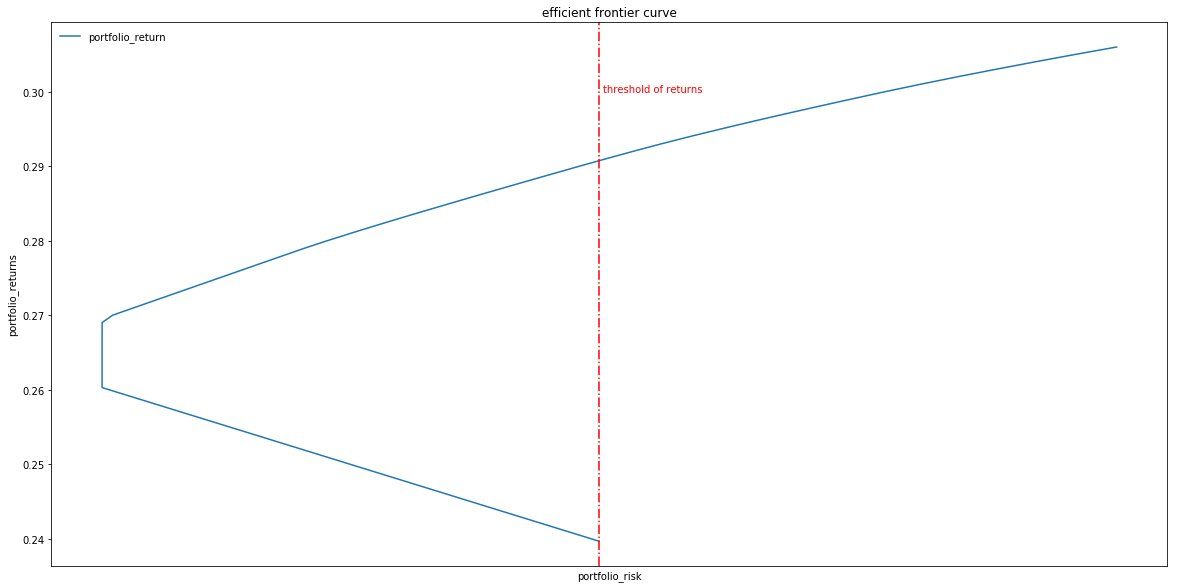

In [406]:
plt.figure(figsize=(20,10))

plt.plot(aggregate_efficient_frontier.portfolio_stdev,aggregate_efficient_frontier.portfolio_return)

plt.legend(loc='upper left', frameon=False)
plt.xlabel("portfolio_risk")
plt.ylabel("portfolio_returns")
plt.title("efficient frontier curve")

# plt.yticks(np.linspace(0,45000,11,endpoint=True))
plt.xticks([])
plt.axvline(x=9.163231e-02, linestyle='-.', color='red',label='testing')
plt.text(9.23238e-02, 0.30,'threshold of returns',color='red')

plt.show()

### We reject any returns beyond the red vertical --> the risk to reward ratio is not worth it for the amount of additional returns
- looking at returns between 0.27 to 0.290
- lets say we are willing to forego a little returns for lower variance, and we choose to settle at 0.275 (which is our initial return we first run)
- below is the allocation we are interested in

In [417]:
portfolio_weights_sort_weight.query("weightage > 0.00001").head(15)

,weightage,ticker,nominal_amount_every_1000,avg_yearly_returns,yearly_variance,default_weights,cumsum_weightage
5,0.3885,CHE,388.539982,0.277657,0.029127,0.017544,0.3885
53,0.1717,USPH,171.700404,0.268261,0.016405,0.017544,0.5602
27,0.1557,MLAB,155.654454,0.281478,0.064973,0.017544,0.7159
21,0.1105,KWR,110.470171,0.261642,0.068269,0.017544,0.8264
52,0.0836,UNH,83.558845,0.255767,0.019347,0.017544,0.9100
23,0.0705,LII,70.524386,0.306971,0.037921,0.017544,0.9805
29,0.0195,MOH,19.540478,0.272168,0.048041,0.017544,1.0000


### Cross checking how the top 7 stocks correlates to one another

In [415]:
(
    golden_cluster_correlation_df[['CHE','USPH','MLAB','KWR','UNH','LII','MOH']]
    .reset_index()
    .query("index in ('CHE','USPH','MLAB','KWR','UNH','LII','MOH')")
    .rename(columns={"index":"ticker"})
)

,ticker,CHE,USPH,MLAB,KWR,UNH,LII,MOH
5,CHE,1.000000,-0.665570,-0.729724,-0.672248,-0.064597,0.001909,0.342591
21,KWR,-0.672248,0.212461,0.076818,1.000000,0.398152,0.182174,-0.395799
23,LII,0.001909,-0.130306,0.026000,0.182174,0.057309,1.000000,-0.372286
27,MLAB,-0.729724,0.654152,1.000000,0.076818,-0.344420,0.026000,-0.058992
29,MOH,0.342591,-0.324398,-0.058992,-0.395799,0.003718,-0.372286,1.000000
52,UNH,-0.064597,-0.653296,-0.344420,0.398152,1.000000,0.057309,0.003718
53,USPH,-0.665570,1.000000,0.654152,0.212461,-0.653296,-0.130306,-0.324398


#### Thankfully, the top 7 stocks seems to be quite balanced, they are not too heavily tilted towards one correlation

### Closing remarks
- There are some limitations to Markowitz mean-variance portfolio optimization
    1. we assume historical returns and variance to be a good indication moving forward
    1. the returns and variance chosen are static, and this will hugely affect the way the weights of the portfolio chosen

### Next steps?
- This strategy could use some backtesting and see how will it beats market returns across the years from 2012 to 2018